In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from numpy import absolute
from numpy import mean, std
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data.csv')
data.drop(columns=['Unnamed: 0'], inplace= True)

In [3]:
len(data)

209

In [4]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close_x', 'Volume', 'Close_y', 'roe',
       'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl', 'dateStr',
       'reddit_sentiment', 'twitter_sentiment', 'Tweets_Volume',
       'Average_Likes'],
      dtype='object')

### Training Data Preparation

In [5]:
# convert data to training data
def series_to_supervised(data, target, quarterly, n_in=1, n_out=1, dropnan=True):    
    df = data.loc[:, list(pd.Series(data.columns).apply(lambda x: x not in  quarterly)) ].copy()
    n_vars = df.shape[1]
    df_quarterly = data.loc[:, list(pd.Series(data.columns).apply(lambda x: x in  quarterly))].copy()
    
    quarterly_dict= {}
    for col in quarterly:
        quarterly_dict[col] = []
        
    for i in range(len(df_quarterly)):
        for col, arr in quarterly_dict.items():
            temp = 0
            if i < n_in - 1:
                arr.append(None)
            else:
                
                for j in range(n_in):
                    temp += float(df_quarterly.iloc[i - j][col])       
                arr.append(temp / n_in)

    for col in quarterly:
        df_quarterly[col] = quarterly_dict[col]
        
    
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if i == 1: 
          names += [ df.columns[j] + '(t)' for j in range(n_vars)]
        else:
          names += [ df.columns[j] +('(t-%d)' % (i-1)) for j in range(n_vars)]
    
    cols.append(df_quarterly.shift(n_in))
    names += list(df_quarterly.columns)
    
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[target].shift(-i))
        names += [ target + ('%d(t+%d)' % (1, i+1))]
        

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Feature Importance 

In [6]:
score_df = pd.DataFrame(columns=['vars', 'mae', 'mse', 'rmse'])

### input = 10, ouput = 1

### Time Series Preprocessing

In [7]:
final_data = data.copy().drop(columns=['Date', 'dateStr'])
train_df = series_to_supervised(final_data, 'Close_x',['roe', 'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl'], 10, 1)

In [8]:
train_df

,Open(t-9),High(t-9),Low(t-9),Close_x(t-9),Volume(t-9),Close_y(t-9),reddit_sentiment(t-9),twitter_sentiment(t-9),Tweets_Volume(t-9),Average_Likes(t-9),...,twitter_sentiment(t),Tweets_Volume(t),Average_Likes(t),roe,debtToEquity,ev/ebitda,eps,gdp,infl,Close_x1(t+1)
19,42.570332,43.339761,41.012113,43.286530,485418400.0,2783.300049,0.000000,0.206934,5647.0,0.864530,...,0.357000,5128.0,1.353549,0.109210,2.230663,4.457843,1.050,21013.0850,0.320826,44.470940
20,43.552680,45.582718,43.400244,45.493195,609369200.0,2832.939941,0.000000,0.247462,7051.0,0.985108,...,0.255825,5803.0,0.982940,0.109210,2.230663,4.457843,1.050,21013.0850,0.358173,43.470230
21,45.573052,47.832951,44.697156,45.667416,799875200.0,2798.360107,0.000000,0.230397,7262.0,1.068025,...,0.198488,6714.0,1.111707,0.109210,2.230663,4.457843,1.050,21013.0850,0.395521,42.093037
22,46.373935,46.669125,44.660862,46.272312,607421200.0,2867.189941,0.000000,0.148224,7170.0,1.047978,...,0.159950,5732.0,0.881368,0.109210,2.230663,4.457843,1.050,21013.0850,0.432868,46.775974
23,46.236016,48.447525,46.226340,48.416073,438240400.0,2895.770020,0.000000,0.335615,5978.0,0.961860,...,0.195010,5788.0,1.026780,0.108702,2.241676,4.407096,1.007,21039.0213,0.466752,47.094170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,152.912464,158.235504,148.087850,150.290833,485408400.0,3655.040039,0.040667,0.083281,9996.0,5.243998,...,0.043767,9832.0,4.185110,0.408924,5.961537,7.956310,1.200,25723.9410,0.044441,146.406464
205,152.254574,154.228277,137.252402,141.997269,598509300.0,3678.429932,-0.200233,0.066860,10514.0,5.537379,...,0.068209,10923.0,8.523666,0.408924,5.961537,7.956310,1.200,25723.9410,0.067130,144.269730
206,144.569074,147.071091,138.129613,139.973724,396527900.0,3612.389893,0.000000,0.215756,10172.0,3.316654,...,0.222123,9992.0,6.671737,0.420913,5.876639,7.429887,1.209,25765.3461,0.108876,132.168198
207,139.455380,144.060708,133.942956,141.957413,434540300.0,3677.949951,0.055871,0.125320,9963.0,3.595202,...,0.105450,10131.0,3.045109,0.432902,5.791741,6.903465,1.218,25806.7512,0.152985,131.658981


In [9]:
train_df.columns

Index(['Open(t-9)', 'High(t-9)', 'Low(t-9)', 'Close_x(t-9)', 'Volume(t-9)',
       'Close_y(t-9)', 'reddit_sentiment(t-9)', 'twitter_sentiment(t-9)',
       'Tweets_Volume(t-9)', 'Average_Likes(t-9)',
       ...
       'twitter_sentiment(t)', 'Tweets_Volume(t)', 'Average_Likes(t)', 'roe',
       'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl', 'Close_x1(t+1)'],
      dtype='object', length=107)

In [10]:
cols_series = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'Average_Likes', 'Tweets_Volume','reddit_sentiment', 'twitter_sentiment', ]
cols_unival = ['roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl', 'Close_x1(t+1)']

In [11]:
col_order = []
cur = pd.Series(train_df.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered.remove('Close_x1(t+1)')
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [12]:
col_order

['Open(t-9)',
 'Open(t-8)',
 'Open(t-7)',
 'Open(t-6)',
 'Open(t-5)',
 'Open(t-4)',
 'Open(t-3)',
 'Open(t-2)',
 'Open(t-1)',
 'Open(t)',
 'High(t-9)',
 'High(t-8)',
 'High(t-7)',
 'High(t-6)',
 'High(t-5)',
 'High(t-4)',
 'High(t-3)',
 'High(t-2)',
 'High(t-1)',
 'High(t)',
 'Low(t-9)',
 'Low(t-8)',
 'Low(t-7)',
 'Low(t-6)',
 'Low(t-5)',
 'Low(t-4)',
 'Low(t-3)',
 'Low(t-2)',
 'Low(t-1)',
 'Low(t)',
 'Close_x(t-9)',
 'Close_x(t-8)',
 'Close_x(t-7)',
 'Close_x(t-6)',
 'Close_x(t-5)',
 'Close_x(t-4)',
 'Close_x(t-3)',
 'Close_x(t-2)',
 'Close_x(t-1)',
 'Close_x(t)',
 'Close_y(t-9)',
 'Close_y(t-8)',
 'Close_y(t-7)',
 'Close_y(t-6)',
 'Close_y(t-5)',
 'Close_y(t-4)',
 'Close_y(t-3)',
 'Close_y(t-2)',
 'Close_y(t-1)',
 'Close_y(t)',
 'Volume(t-9)',
 'Volume(t-8)',
 'Volume(t-7)',
 'Volume(t-6)',
 'Volume(t-5)',
 'Volume(t-4)',
 'Volume(t-3)',
 'Volume(t-2)',
 'Volume(t-1)',
 'Volume(t)',
 'Average_Likes(t-9)',
 'Average_Likes(t-8)',
 'Average_Likes(t-7)',
 'Average_Likes(t-6)',
 'Average_

In [13]:
train_df = train_df[col_order]

In [14]:
train_scaled = train_df.copy()
train_scaled = train_scaled.reset_index().drop('index', axis=1)

In [15]:
train_scaled.columns

Index(['Open(t-9)', 'Open(t-8)', 'Open(t-7)', 'Open(t-6)', 'Open(t-5)',
       'Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       ...
       'twitter_sentiment(t-2)', 'twitter_sentiment(t-1)',
       'twitter_sentiment(t)', 'roe', 'debtToEquity', 'ev/ebitda', 'eps',
       'gdp', 'infl', 'Close_x1(t+1)'],
      dtype='object', length=107)

In [16]:
trform_list = {}

In [17]:
def minmaxscaler(index, row, in_size, num_var):
    trform_dict = {}
    trformed_row = []
    value = 0
    for i in range(num_var):
        cur = np.array(row[ i*in_size : (i+1)*in_size ])
        rowmaxmin = cur.max() - cur.min()
        print('rowmaxmin', rowmaxmin)
        rowmin = cur.min()
        print('rowmin', rowmin)
        trform_dict[i] = [rowmaxmin, rowmin]
        trform_list[index] = trform_dict
        cur = [ (x - rowmin) / (rowmaxmin) for x in cur]
        trformed_row.extend(cur)
        if (i == 3):
            target = row[-1]
            value = (target - rowmin) / rowmaxmin
    
    rest = np.array(row[ num_var*in_size : -1 ])
    trformed_row.extend(rest)
    trformed_row.append(value)
    return trformed_row
            

In [18]:
for index, row in train_scaled.iterrows():
    trformed_row = minmaxscaler(index, row, 10, 8)
    train_scaled.loc[index] = trformed_row

rowmaxmin 7.244265072168879
rowmin 42.57033187789256
rowmaxmin 8.756513389072879
rowmin 43.339760897437785
rowmaxmin 7.892712051229047
rowmin 41.01211295427737
rowmaxmin 7.157161712646484
rowmin 43.286529541015625
rowmaxmin 159.72998046875
rowmin 2783.300048828125
rowmaxmin 406921200.0
rowmin 392954000.0
rowmaxmin 1.595535360821513
rowmin 0.864529838852488
rowmaxmin 3013.0
rowmin 4349.0
rowmaxmin 6.261917243982623
rowmin 43.55267970607882
rowmaxmin 6.513555935145426
rowmin 45.58271835136524
rowmaxmin 5.504580859840921
rowmin 43.400244145665496
rowmaxmin 5.972751617431641
rowmin 44.47093963623047
rowmaxmin 144.669921875
rowmin 2798.360107421875
rowmaxmin 406921200.0
rowmin 392954000.0
rowmaxmin 1.4982050457763765
rowmin 0.9618601538976246
rowmaxmin 3013.0
rowmin 4349.0
rowmaxmin 4.826297135907268
rowmin 44.988299814154175
rowmaxmin 6.432737361128076
rowmin 45.66353692538259
rowmaxmin 5.716349530937087
rowmin 43.18847547456933
rowmaxmin 6.973461151123047
rowmin 43.47023010253906
rowmaxmi

rowmaxmin 21.38483122878838
rowmin 57.93807049933243
rowmaxmin 17.063250893923552
rowmin 63.147007173878805
rowmaxmin 26.007906970590128
rowmin 52.11632311324463
rowmaxmin 24.654815673828125
rowmin 54.99900817871094
rowmaxmin 1142.760009765625
rowmin 2237.39990234375
rowmaxmin 1269603600.0
rowmin 382914800.0
rowmaxmin 0.9294088576855952
rowmin 1.1605166051660516
rowmaxmin 3504.0
rowmin 4159.0
rowmaxmin 19.364972427713433
rowmin 57.93807049933243
rowmaxmin 16.433261662282106
rowmin 63.147007173878805
rowmaxmin 18.78157450728267
rowmin 52.11632311324463
rowmaxmin 18.2471923828125
rowmin 54.99900817871094
rowmaxmin 988.489990234375
rowmin 2237.39990234375
rowmaxmin 987878400.0
rowmin 664640000.0
rowmaxmin 0.9586392389897924
rowmin 1.1605166051660516
rowmaxmin 3504.0
rowmin 4159.0
rowmaxmin 16.49946152800586
rowmin 57.93807049933243
rowmaxmin 11.371413268368656
rowmin 63.147007173878805
rowmaxmin 16.077847337618735
rowmin 52.11632311324463
rowmaxmin 18.2471923828125
rowmin 54.9990081787109

rowmin 3577.590087890625
rowmaxmin 281197000.0
rowmin 382408200.0
rowmaxmin 4.394626412094324
rowmin 3.517692307692308
rowmaxmin 3656.0
rowmin 4526.0
rowmaxmin 29.29307054224782
rowmin 112.38721022432904
rowmaxmin 23.797545908662343
rowmin 119.35282697695898
rowmaxmin 17.384437117041642
rowmin 111.08484927379584
rowmaxmin 23.550888061523438
rowmin 117.45849609375
rowmaxmin 233.730224609375
rowmin 3621.6298828125
rowmaxmin 283210900.0
rowmin 382408200.0
rowmaxmin 4.394626412094324
rowmin 3.517692307692308
rowmaxmin 6671.0
rowmin 4526.0
rowmaxmin 22.287984364026812
rowmin 119.39229640255004
rowmaxmin 20.245670267017488
rowmin 122.90470261860384
rowmaxmin 13.4182051095474
rowmin 118.40566476636396
rowmaxmin 20.857391357421875
rowmin 120.15199279785156
rowmaxmin 268.10009765625
rowmin 3647.489990234375
rowmaxmin 283210900.0
rowmin 382408200.0
rowmaxmin 4.394626412094324
rowmin 3.517692307692308
rowmaxmin 5705.0
rowmin 5492.0
rowmaxmin 19.00249985649549
rowmin 122.67778091008137
rowmaxmin 1

rowmin 145.27023315429688
rowmaxmin 215.240234375
rowmin 4486.4599609375
rowmaxmin 437559500.0
rowmin 286001800.0
rowmaxmin 3.7493144112777594
rowmin 4.668848019857836
rowmaxmin 4788.0
rowmin 5496.0
rowmaxmin 28.246931516862304
rowmin 145.72619424989745
rowmaxmin 31.93449643269892
rowmin 148.86850964477398
rowmaxmin 22.756337131895805
rowmin 145.13146011303004
rowmaxmin 31.674163818359375
rowmin 147.3419647216797
rowmaxmin 224.7099609375
rowmin 4566.47998046875
rowmaxmin 437559500.0
rowmin 286001800.0
rowmaxmin 3.8068178933204697
rowmin 4.611344537815126
rowmaxmin 4788.0
rowmin 5496.0
rowmaxmin 31.485590109868554
rowmin 147.3617816035945
rowmaxmin 30.7741280484355
rowmin 150.7734271657591
rowmaxmin 30.83703168911606
rowmin 145.13146011303004
rowmaxmin 33.024688720703125
rowmin 147.65919494628906
rowmaxmin 228.5400390625
rowmin 4568.02001953125
rowmaxmin 437559500.0
rowmin 286001800.0
rowmaxmin 3.8068178933204697
rowmin 4.611344537815126
rowmaxmin 4788.0
rowmin 5496.0
rowmaxmin 33.93757

rowmin 133.94295599666086
rowmaxmin 24.432113647460938
rowmin 138.47848510742188
rowmaxmin 498.020263671875
rowmin 3612.389892578125
rowmaxmin 210561900.0
rowmin 387947400.0
rowmaxmin 4.893421468006451
rowmin 3.316653558788832
rowmaxmin 1753.0
rowmin 9443.0
rowmaxmin 19.93642133918192
rowmin 139.4553799757714
rowmaxmin 15.969059093790122
rowmin 144.06070757107167
rowmaxmin 14.144893572093082
rowmin 133.94295599666086
rowmaxmin 15.510543823242188
rowmin 138.47848510742188
rowmaxmin 344.860107421875
rowmin 3612.389892578125
rowmaxmin 230479600.0
rowmin 368029700.0
rowmaxmin 4.893421468006451
rowmin 3.316653558788832
rowmaxmin 1302.0
rowmin 9894.0
rowmaxmin 15.131749358220475
rowmin 139.4553799757714
rowmaxmin 14.174796200683858
rowmin 144.06070757107167
rowmaxmin 14.144893572093082
rowmin 133.94295599666086
rowmaxmin 14.374176025390625
rowmin 138.47848510742188
rowmaxmin 351.550048828125
rowmin 3612.389892578125
rowmaxmin 383961900.0
rowmin 214547400.0
rowmaxmin 4.893421468006451
rowmin 

In [19]:
trform_list

{0: {0: [7.244265072168879, 42.57033187789256],
  1: [8.756513389072879, 43.339760897437785],
  2: [7.892712051229047, 41.01211295427737],
  3: [7.157161712646484, 43.286529541015625],
  4: [159.72998046875, 2783.300048828125],
  5: [406921200.0, 392954000.0],
  6: [1.595535360821513, 0.864529838852488],
  7: [3013.0, 4349.0]},
 1: {0: [6.261917243982623, 43.55267970607882],
  1: [6.513555935145426, 45.58271835136524],
  2: [5.504580859840921, 43.400244145665496],
  3: [5.972751617431641, 44.47093963623047],
  4: [144.669921875, 2798.360107421875],
  5: [406921200.0, 392954000.0],
  6: [1.4982050457763765, 0.9618601538976246],
  7: [3013.0, 4349.0]},
 2: {0: [4.826297135907268, 44.988299814154175],
  1: [6.432737361128076, 45.66353692538259],
  2: [5.716349530937087, 43.18847547456933],
  3: [6.973461151123047, 43.47023010253906],
  4: [144.669921875, 2798.360107421875],
  5: [406921200.0, 392954000.0],
  6: [1.4982050457763765, 0.9618601538976246],
  7: [3013.0, 4349.0]},
 3: {0: [6.3

In [20]:
train_scaled.columns

Index(['Open(t-9)', 'Open(t-8)', 'Open(t-7)', 'Open(t-6)', 'Open(t-5)',
       'Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       ...
       'twitter_sentiment(t-2)', 'twitter_sentiment(t-1)',
       'twitter_sentiment(t)', 'roe', 'debtToEquity', 'ev/ebitda', 'eps',
       'gdp', 'infl', 'Close_x1(t+1)'],
      dtype='object', length=107)

In [21]:
train_scaled

,Open(t-9),Open(t-8),Open(t-7),Open(t-6),Open(t-5),Open(t-4),Open(t-3),Open(t-2),Open(t-1),Open(t),...,twitter_sentiment(t-2),twitter_sentiment(t-1),twitter_sentiment(t),roe,debtToEquity,ev/ebitda,eps,gdp,infl,Close_x1(t+1)
0,0.000000,0.135604,0.414496,0.525050,0.506012,0.814296,0.785572,0.951569,0.905812,1.000000,...,0.296578,0.235196,0.357000,0.109210,2.230663,4.457843,1.050,21013.0850,0.320826,0.165486
1,0.000000,0.322644,0.450542,0.428517,0.785164,0.751933,0.943971,0.891036,1.000000,0.275420,...,0.235196,0.357000,0.255825,0.109210,2.230663,4.457843,1.050,21013.0850,0.358173,-0.167546
2,0.121160,0.287101,0.258525,0.721259,0.678143,0.927305,0.858623,1.000000,0.059889,0.000000,...,0.357000,0.255825,0.198488,0.109210,2.230663,4.457843,1.050,21013.0850,0.395521,-0.197491
3,0.458719,0.437021,0.788361,0.755625,0.944805,0.892657,1.000000,0.286203,0.240732,0.000000,...,0.255825,0.198488,0.159950,0.109210,2.230663,4.457843,1.050,21013.0850,0.432868,0.560787
4,0.503098,0.813201,0.784307,0.951283,0.905256,1.000000,0.369981,0.329846,0.117369,0.000000,...,0.198488,0.159950,0.195010,0.108702,2.241676,4.407096,1.007,21039.0213,0.466752,0.598891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,0.889328,0.845850,0.337945,0.000000,0.368248,0.671278,1.000000,0.048941,0.828229,0.558349,...,0.093421,0.091963,0.043767,0.408924,5.961537,7.956310,1.200,25723.9410,0.044441,0.551543
186,0.845850,0.337945,0.000000,0.368248,0.671278,1.000000,0.048941,0.828229,0.558349,0.304964,...,0.091963,0.043767,0.068209,0.408924,5.961537,7.956310,1.200,25723.9410,0.067130,0.402892
187,0.337945,0.000000,0.368248,0.671278,1.000000,0.048941,0.828229,0.558349,0.304964,0.488405,...,0.043767,0.068209,0.222123,0.420913,5.876639,7.429887,1.209,25765.3461,0.108876,-0.439002
188,0.000000,0.368248,0.671278,1.000000,0.048941,0.828229,0.558349,0.304964,0.488405,0.648749,...,0.068209,0.222123,0.105450,0.432902,5.791741,6.903465,1.218,25806.7512,0.152985,-0.024618


### Coefficient as Feature Importance

In [22]:
x = train_scaled.drop('Close_x1(t+1)', axis=1)
y = train_scaled['Close_x1(t+1)']

In [23]:
# Take last 50 days as test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [24]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [25]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [26]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past10_LR', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 12.61181090855868
Mean Squared Error: 253.10740640994837
Root Mean Squared Error: 15.909349653896868
R-squared: -0.6615788441856079


<AxesSubplot:>

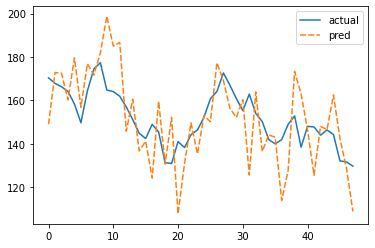

In [27]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-9), Score: -0.0620542496
Feature: Open(t-8), Score: 0.7009962608
Feature: Open(t-7), Score: -0.3184066125
Feature: Open(t-6), Score: 1.3755244703
Feature: Open(t-5), Score: -1.6669130563
Feature: Open(t-4), Score: 0.4716914943
Feature: Open(t-3), Score: 0.0873472014
Feature: Open(t-2), Score: -0.1922097475
Feature: Open(t-1), Score: -0.1991657674
Feature: Open(t), Score: 0.0155806752
Feature: High(t-9), Score: 0.1389550528
Feature: High(t-8), Score: 0.1938394467
Feature: High(t-7), Score: -0.2909738496
Feature: High(t-6), Score: -0.4683272845
Feature: High(t-5), Score: -0.1071252646
Feature: High(t-4), Score: -0.0911454735
Feature: High(t-3), Score: -0.2440267496
Feature: High(t-2), Score: 0.1097110495
Feature: High(t-1), Score: -0.1517398423
Feature: High(t), Score: -0.1819146998
Feature: Low(t-9), Score: -0.2009010506
Feature: Low(t-8), Score: 0.0053701658
Feature: Low(t-7), Score: 0.2077710752
Feature: Low(t-6), Score: 0.4931105726
Feature: Low(t-5), Score: 0.2910205

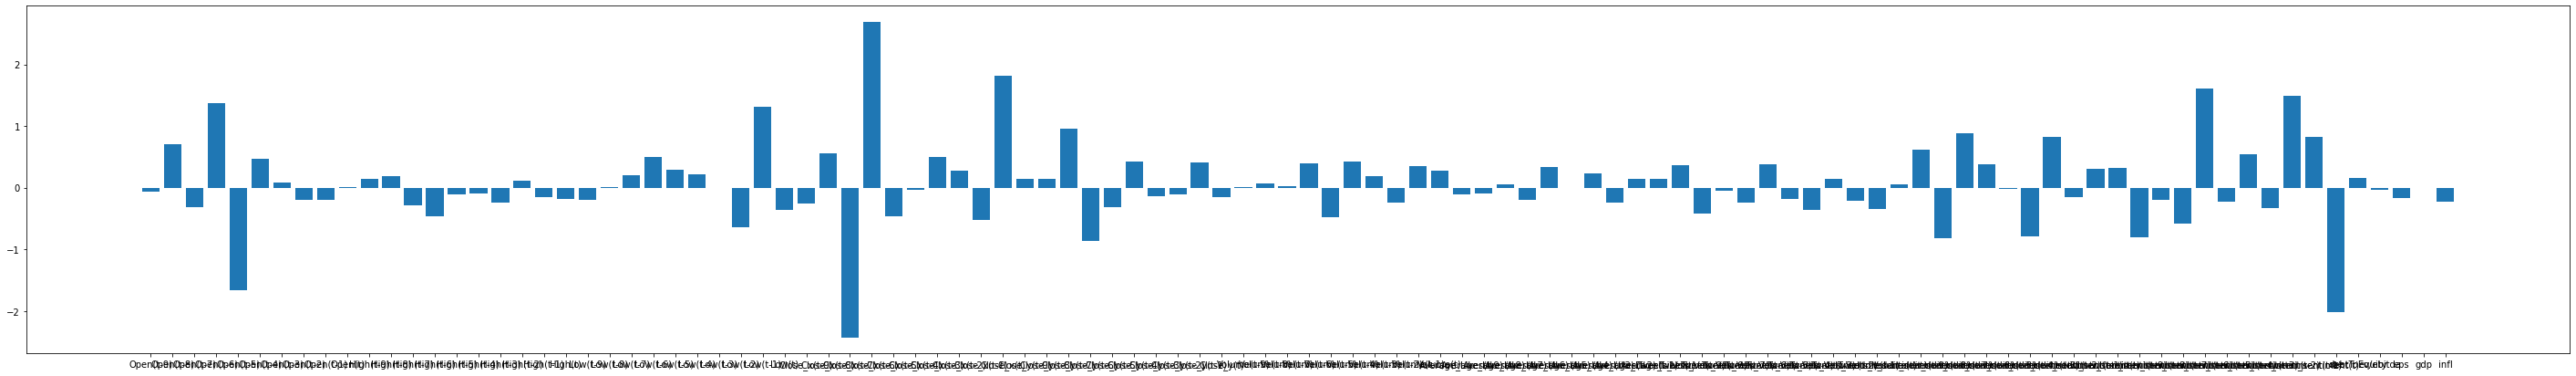

In [28]:
# get importance
importance = best_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

### Input : 5 Output : 1

### Coefficient as Feature Importance

In [29]:
final_data = data.copy().drop(columns=['Date', 'dateStr'])
train_df = series_to_supervised(final_data, 'Close_x',['roe', 'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl'], 5, 1)

In [30]:
cols_series = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume','Average_Likes', 'Tweets_Volume', 'reddit_sentiment', 'twitter_sentiment']
cols_unival = ['roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl', 'Close_x1(t+1)']

In [31]:
col_order = []
cur = pd.Series(train_df.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered.remove('Close_x1(t+1)')
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [32]:
train_df = train_df[col_order]

In [33]:
train_df.iloc[150]

Open(t-4)                 1.739731e+02
Open(t-3)                 1.703100e+02
Open(t-2)                 1.788474e+02
Open(t-1)                 1.812994e+02
Open(t)                   1.710645e+02
High(t-4)                 1.798202e+02
High(t-3)                 1.791055e+02
High(t-2)                 1.815476e+02
High(t-1)                 1.816071e+02
High(t)                   1.758890e+02
Low(t-4)                  1.662399e+02
Low(t-3)                  1.678878e+02
Low(t-2)                  1.759685e+02
Low(t-1)                  1.669447e+02
Low(t)                    1.695754e+02
Close_x(t-4)              1.685132e+02
Close_x(t-3)              1.790161e+02
Close_x(t-2)              1.806839e+02
Close_x(t-1)              1.709354e+02
Close_x(t)                1.718090e+02
Close_y(t-4)              4.568020e+03
Close_y(t-3)              4.791190e+03
Close_y(t-2)              4.796560e+03
Close_y(t-1)              4.670290e+03
Close_y(t)                4.662850e+03
Volume(t-4)              

In [34]:
train_scaled = train_df.copy()
train_scaled = train_scaled.reset_index().drop('index', axis=1)

In [35]:
trform_list = {}

In [36]:
for index, row in train_scaled.iterrows():
    trformed_row = minmaxscaler(index, row, 5, 8)
    train_scaled.loc[index] = trformed_row

rowmaxmin 4.386079613386933
rowmin 37.64469606162858
rowmaxmin 1.6509227335008987
rowmin 41.3573674483082
rowmaxmin 4.664538315685384
rowmin 37.12911445141811
rowmaxmin 1.7284622192382812
rowmin 40.820106506347656
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 465456000.0
rowmin 364944800.0
rowmaxmin 1.5851742151109245
rowmin 1.0555014605647517
rowmaxmin 2621.0
rowmin 4779.0
rowmaxmin 1.5074000263543113
rowmin 41.06293185153825
rowmaxmin 1.606610688591502
rowmin 41.73315020884628
rowmaxmin 1.2168802932300125
rowmin 40.57677247387348
rowmaxmin 2.4664230346679688
rowmin 40.820106506347656
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 198640400.0
rowmin 364944800.0
rowmaxmin 0.24155930113495705
rowmin 0.864529838852488
rowmaxmin 868.0
rowmin 4779.0
rowmaxmin 2.4897478545405676
rowmin 41.06293185153825
rowmaxmin 3.8495681425189545
rowmin 41.73315020884628
rowmaxmin 2.417165752529293
rowmin 40.9830783931362
rowmaxmin 4.258480072021484
rowmin 41.23471450805664
rowm

rowmin 3243.6298828125
rowmaxmin 377587200.0
rowmin 500996000.0
rowmaxmin 1.9907198282575427
rowmin 1.7122648841908907
rowmaxmin 2466.0
rowmin 5776.0
rowmaxmin 4.242874150916961
rowmin 73.32467274996104
rowmaxmin 2.6362106327410686
rowmin 77.53820307440458
rowmaxmin 4.027667269578387
rowmin 72.66929125208206
rowmaxmin 3.1521835327148438
rowmin 75.48157501220703
rowmaxmin 108.460205078125
rowmin 3243.6298828125
rowmaxmin 348059600.0
rowmin 530523600.0
rowmaxmin 2.019339056571091
rowmin 1.6836456558773425
rowmaxmin 2372.0
rowmin 5870.0
rowmaxmin 2.8778148053947774
rowmin 76.44508692272603
rowmaxmin 2.263664850466597
rowmin 77.94659321733576
rowmaxmin 4.217532028772908
rowmin 73.90669805506185
rowmaxmin 4.172248840332031
rowmin 75.48157501220703
rowmaxmin 136.530029296875
rowmin 3243.6298828125
rowmaxmin 495668400.0
rowmin 382914800.0
rowmaxmin 2.019339056571091
rowmin 1.6836456558773425
rowmaxmin 2634.0
rowmin 5608.0
rowmaxmin 2.8778148053947774
rowmin 76.44508692272603
rowmaxmin 1.14120

rowmaxmin 15.37479122754226
rowmin 108.00768393451118
rowmaxmin 7.987805104178122
rowmin 115.51286464793124
rowmaxmin 8.214342605866463
rowmin 105.70293935706138
rowmaxmin 11.560691833496108
rowmin 107.13108825683594
rowmaxmin 316.669921875
rowmin 3310.239990234375
rowmaxmin 250853800.0
rowmin 510781000.0
rowmaxmin 1.6439894783811413
rowmin 2.1921751120303345
rowmaxmin 2595.0
rowmin 5802.0
rowmaxmin 9.944131481530349
rowmin 108.00768393451118
rowmaxmin 4.63902931917012
rowmin 115.51286464793124
rowmaxmin 6.901318266146944
rowmin 105.70293935706138
rowmaxmin 11.560691833496108
rowmin 107.13108825683594
rowmaxmin 316.669921875
rowmin 3310.239990234375
rowmaxmin 269213600.0
rowmin 426269700.0
rowmaxmin 1.9084373114167348
rowmin 2.1921751120303345
rowmaxmin 3375.0
rowmin 4572.0
rowmaxmin 9.944131481530349
rowmin 108.00768393451118
rowmaxmin 4.63902931917012
rowmin 115.51286464793124
rowmaxmin 6.901318266146944
rowmin 105.70293935706138
rowmaxmin 11.560691833496108
rowmin 107.13108825683594

rowmaxmin 290228300.0
rowmin 259155900.0
rowmaxmin 1.5460174385075787
rowmin 4.508086063844748
rowmaxmin 2521.0
rowmin 6336.0
rowmaxmin 8.957519463913684
rowmin 138.63911173165903
rowmaxmin 3.642376102993893
rowmin 144.82526439114451
rowmaxmin 5.0577912441179365
rowmin 138.63911173165903
rowmaxmin 6.47320556640625
rowmin 140.99476623535156
rowmaxmin 173.85986328125
rowmin 4258.490234375
rowmaxmin 278796100.0
rowmin 270588100.0
rowmaxmin 1.8766343665498573
rowmin 4.177469135802469
rowmaxmin 3673.0
rowmin 5184.0
rowmaxmin 5.602165494776301
rowmin 141.9944657007964
rowmaxmin 3.342001751090237
rowmin 146.52768718124352
rowmaxmin 3.8083900730530615
rowmin 140.22273571301477
rowmaxmin 8.805526733398438
rowmin 140.99476623535156
rowmaxmin 221.2197265625
rowmin 4258.490234375
rowmaxmin 278796100.0
rowmin 270588100.0
rowmaxmin 1.8766343665498573
rowmin 4.177469135802469
rowmaxmin 3428.0
rowmin 5184.0
rowmaxmin 6.923616070171192
rowmin 141.9944657007964
rowmaxmin 3.8277291450521886
rowmin 146.52

rowmaxmin 483.400146484375
rowmin 3674.840087890625
rowmaxmin 40766100.0
rowmin 378195400.0
rowmaxmin 2.3082024337279723
rowmin 3.5969550173010383
rowmaxmin 1003.0
rowmin 7225.0
rowmaxmin 15.867317465437026
rowmin 132.52282300096547
rowmaxmin 14.334348069832828
rowmin 136.71361344619984
rowmaxmin 15.349699579438749
rowmin 128.45146520768822
rowmaxmin 14.513519287109375
rowmin 130.95997619628906
rowmaxmin 446.590087890625
rowmin 3674.840087890625
rowmaxmin 115619600.0
rowmin 303341900.0
rowmaxmin 2.3082024337279723
rowmin 3.5969550173010383
rowmaxmin 841.0
rowmin 7225.0
rowmaxmin 11.16882296984977
rowmin 132.52282300096547
rowmaxmin 12.47284564257626
rowmin 136.71361344619984
rowmaxmin 7.854019282795292
rowmin 128.45146520768822
rowmaxmin 13.249298095703125
rowmin 130.95997619628906
rowmaxmin 225.27001953125
rowmin 3674.840087890625
rowmaxmin 115619600.0
rowmin 303341900.0
rowmaxmin 2.3082024337279723
rowmin 3.5969550173010383
rowmaxmin 1076.0
rowmin 6990.0
rowmaxmin 12.572400264382622


In [37]:
train_scaled.iloc[150]

Open(t-4)                     0.333332
Open(t-3)                     0.000000
Open(t-2)                     0.776876
Open(t-1)                     1.000000
Open(t)                       0.068653
High(t-4)                     0.687500
High(t-3)                     0.562503
High(t-2)                     0.989586
High(t-1)                     1.000000
High(t)                       0.000000
Low(t-4)                      0.000000
Low(t-3)                      0.169388
Low(t-2)                      1.000000
Low(t-1)                      0.072448
Low(t)                        0.342856
Close_x(t-4)                  0.000000
Close_x(t-3)                  0.862969
Close_x(t-2)                  1.000000
Close_x(t-1)                  0.199021
Close_x(t)                    0.270799
Close_y(t-4)                  0.000000
Close_y(t-3)                  0.976503
Close_y(t-2)                  1.000000
Close_y(t-1)                  0.447493
Close_y(t)                    0.414939
Volume(t-4)              

In [38]:
x = train_scaled.drop('Close_x1(t+1)', axis=1)
y = train_scaled['Close_x1(t+1)']

In [39]:
X_train.index.max()

141

In [40]:
X_test.index.min()

142

In [41]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [42]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [43]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [44]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past5_LR', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 7.990337119205423
Mean Squared Error: 88.88284809875519
Root Mean Squared Error: 9.427770049102556
R-squared: 0.4323973430960705


<AxesSubplot:>

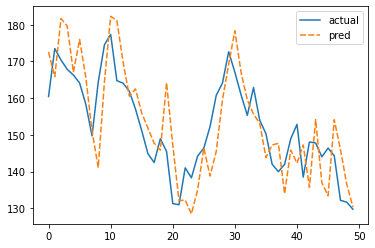

In [45]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-4), Score: 0.3348119025
Feature: Open(t-3), Score: -0.0862248329
Feature: Open(t-2), Score: 0.1398759918
Feature: Open(t-1), Score: -0.2999231318
Feature: Open(t), Score: 0.2945094200
Feature: High(t-4), Score: -0.3458649697
Feature: High(t-3), Score: -0.3803982645
Feature: High(t-2), Score: -0.0700478744
Feature: High(t-1), Score: 0.0784221597
Feature: High(t), Score: -0.5963045209
Feature: Low(t-4), Score: -0.3426111358
Feature: Low(t-3), Score: 0.3272901814
Feature: Low(t-2), Score: 0.3521725604
Feature: Low(t-1), Score: 0.0938644223
Feature: Low(t), Score: -0.5568844417
Feature: Close_x(t-4), Score: -0.1604226681
Feature: Close_x(t-3), Score: 0.0977926762
Feature: Close_x(t-2), Score: 0.0046955488
Feature: Close_x(t-1), Score: -0.0070949397
Feature: Close_x(t), Score: 1.6599619099
Feature: Close_y(t-4), Score: 0.5508186271
Feature: Close_y(t-3), Score: -0.1443744602
Feature: Close_y(t-2), Score: 0.1948607837
Feature: Close_y(t-1), Score: 0.0916169870
Feature: Close_

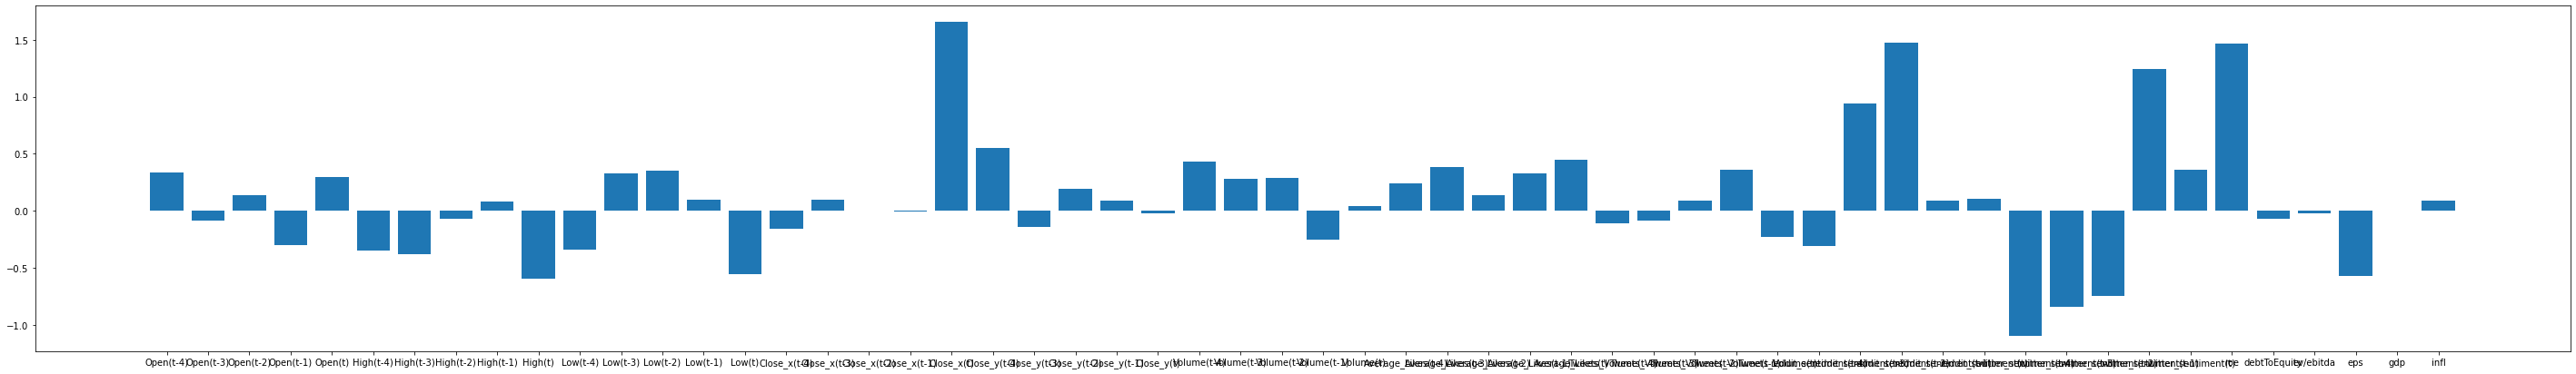

In [46]:
# get importance
importance = best_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

Feature: Open, Score: 0.3830493496
Feature: High, Score: -1.3141934698
Feature: Low, Score: -0.1261684134
Feature: Close_x, Score: 1.5949325270
Feature: Close_y, Score: 0.6724996497
Feature: Volume, Score: 0.7822428038
Feature: Average_Likes, Score: 1.5475254533
Feature: Tweets_Volume, Score: 0.0256934885
Feature: reddit_sentiment, Score: 2.3025934081
Feature: twitter_sentiment, Score: -1.0826708142
Feature: roe, Score: 1.4633442749
Feature: debtToEquity, Score: -0.0742179951
Feature: ev/ebitda, Score: -0.0263558427
Feature: eps, Score: -0.5684751524
Feature: gdp, Score: -0.0000689271
Feature: infl, Score: 0.0896616807


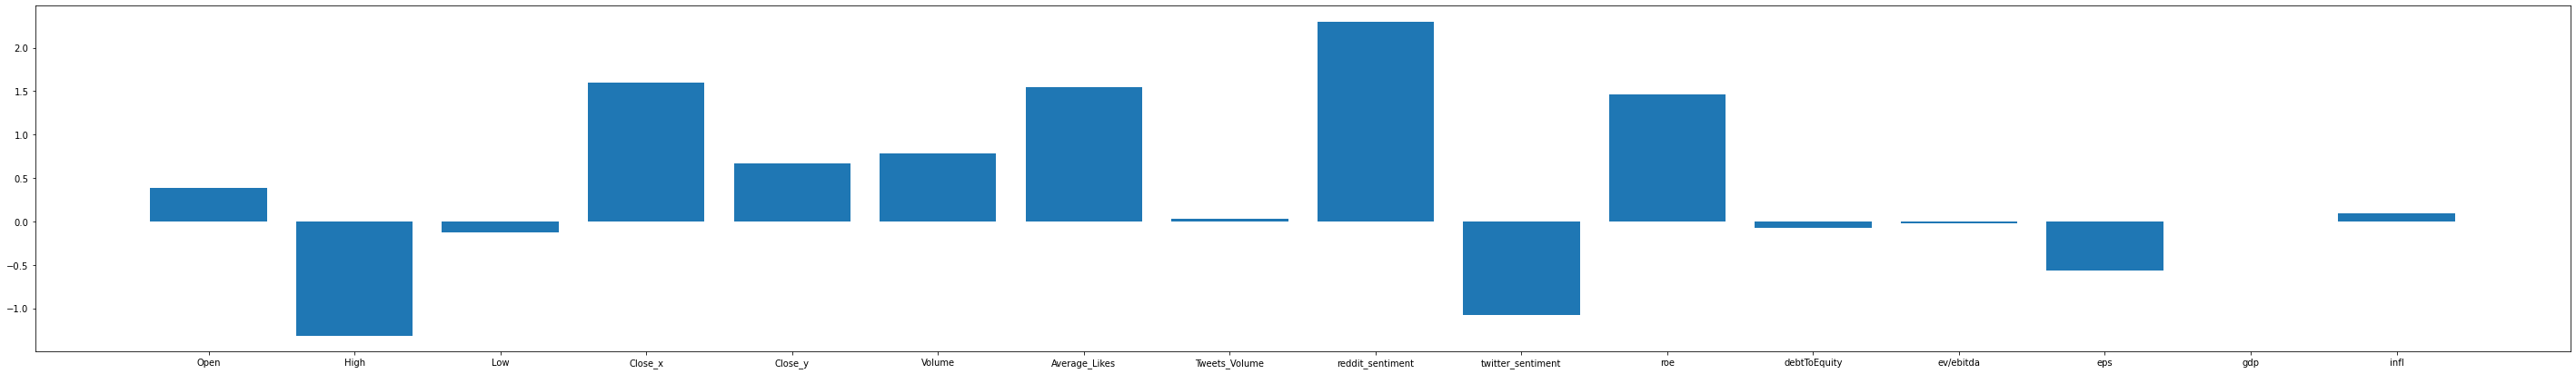

In [47]:
# get importance
importance = best_model.coef_

cols = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'Average_Likes', 'Tweets_Volume','reddit_sentiment', 'twitter_sentiment','roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl']

agg_impt = []
cur = 0
cur_var = 'Open'
at = 0
for i,v in enumerate(importance):
    if (col_order[i].find(cur_var) > -1):
        cur += v
    else: 
        agg_impt.append(cur)
        print(f'Feature: {cols[at]}, Score: {cur:.10f}')
        at += 1
        cur_var = cols[at]
        cur = v
agg_impt.append(cur)
print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([cols[x] for x in range(len(cols))], agg_impt)
plt.show()

### Random Forest Feature Importance

In [48]:
from sklearn.ensemble import RandomForestRegressor

best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)

RandomForestRegressor()

In [49]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past5_RF', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 7.146927363702589
Mean Squared Error: 72.03574303998346
Root Mean Squared Error: 8.487387291739635
R-squared: 0.539982347369042


<AxesSubplot:>

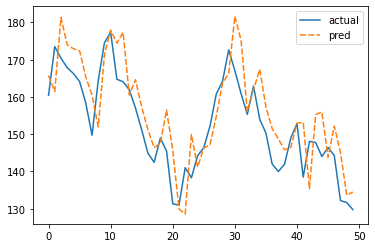

In [50]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-4), Score: 0.0016409339
Feature: Open(t-3), Score: 0.0059155201
Feature: Open(t-2), Score: 0.0073619996
Feature: Open(t-1), Score: 0.0092975652
Feature: Open(t), Score: 0.0053591881
Feature: High(t-4), Score: 0.0022881493
Feature: High(t-3), Score: 0.0117391891
Feature: High(t-2), Score: 0.0132151295
Feature: High(t-1), Score: 0.0087825103
Feature: High(t), Score: 0.0025417369
Feature: Low(t-4), Score: 0.0029878453
Feature: Low(t-3), Score: 0.0102140897
Feature: Low(t-2), Score: 0.0073719897
Feature: Low(t-1), Score: 0.0077161317
Feature: Low(t), Score: 0.0491072530
Feature: Close_x(t-4), Score: 0.0199942282
Feature: Close_x(t-3), Score: 0.0183490309
Feature: Close_x(t-2), Score: 0.0110956850
Feature: Close_x(t-1), Score: 0.0049113297
Feature: Close_x(t), Score: 0.3490878281
Feature: Close_y(t-4), Score: 0.0030769490
Feature: Close_y(t-3), Score: 0.0054493999
Feature: Close_y(t-2), Score: 0.0175038754
Feature: Close_y(t-1), Score: 0.0062244045
Feature: Close_y(t), Score

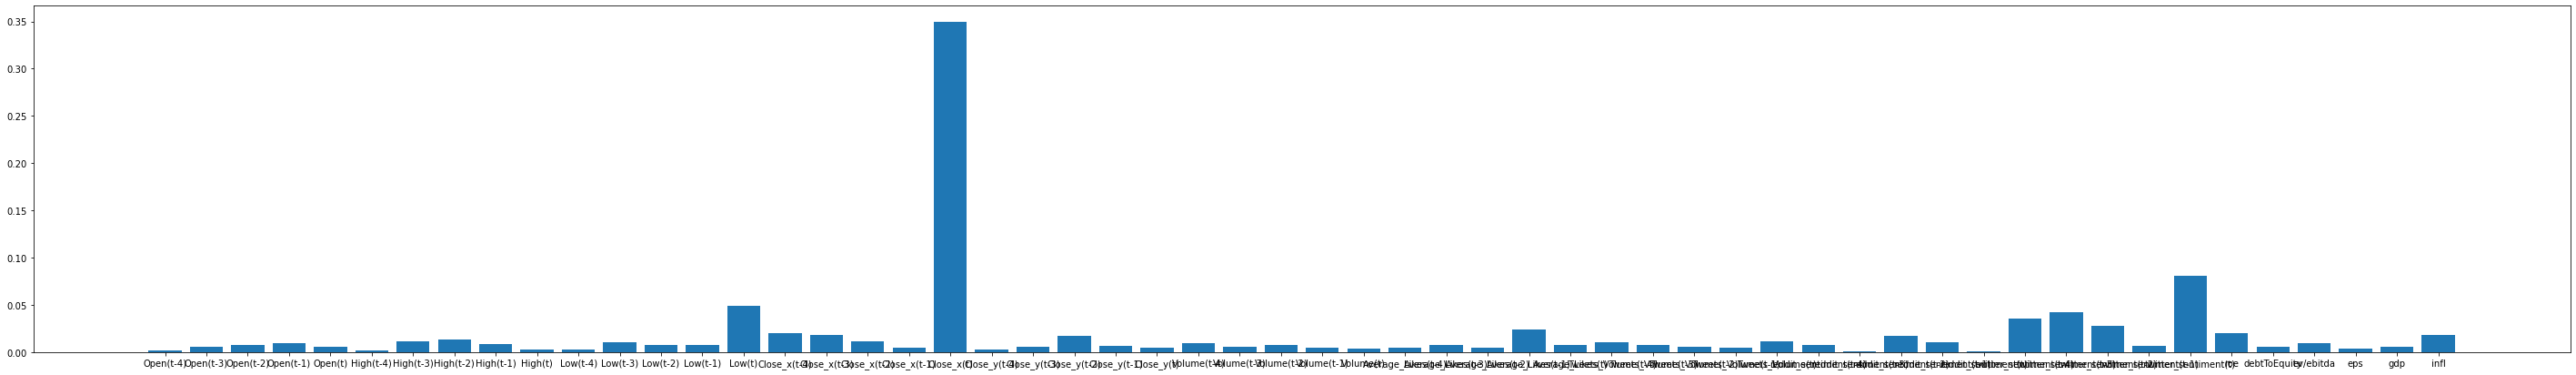

In [51]:
# get importance
importance = best_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

Feature: Open, Score: 0.0295752069
Feature: High, Score: 0.0385667151
Feature: Low, Score: 0.0773973094
Feature: Close_x, Score: 0.4034381019
Feature: Close_y, Score: 0.0372851492
Feature: Volume, Score: 0.0316202897
Feature: Average_Likes, Score: 0.0480721362
Feature: Tweets_Volume, Score: 0.0405570088
Feature: reddit_sentiment, Score: 0.0373952880
Feature: twitter_sentiment, Score: 0.1927679119
Feature: roe, Score: 0.0203641585
Feature: debtToEquity, Score: 0.0058267982
Feature: ev/ebitda, Score: 0.0096577132
Feature: eps, Score: 0.0038492987
Feature: gdp, Score: 0.0052499189
Feature: infl, Score: 0.0183769955


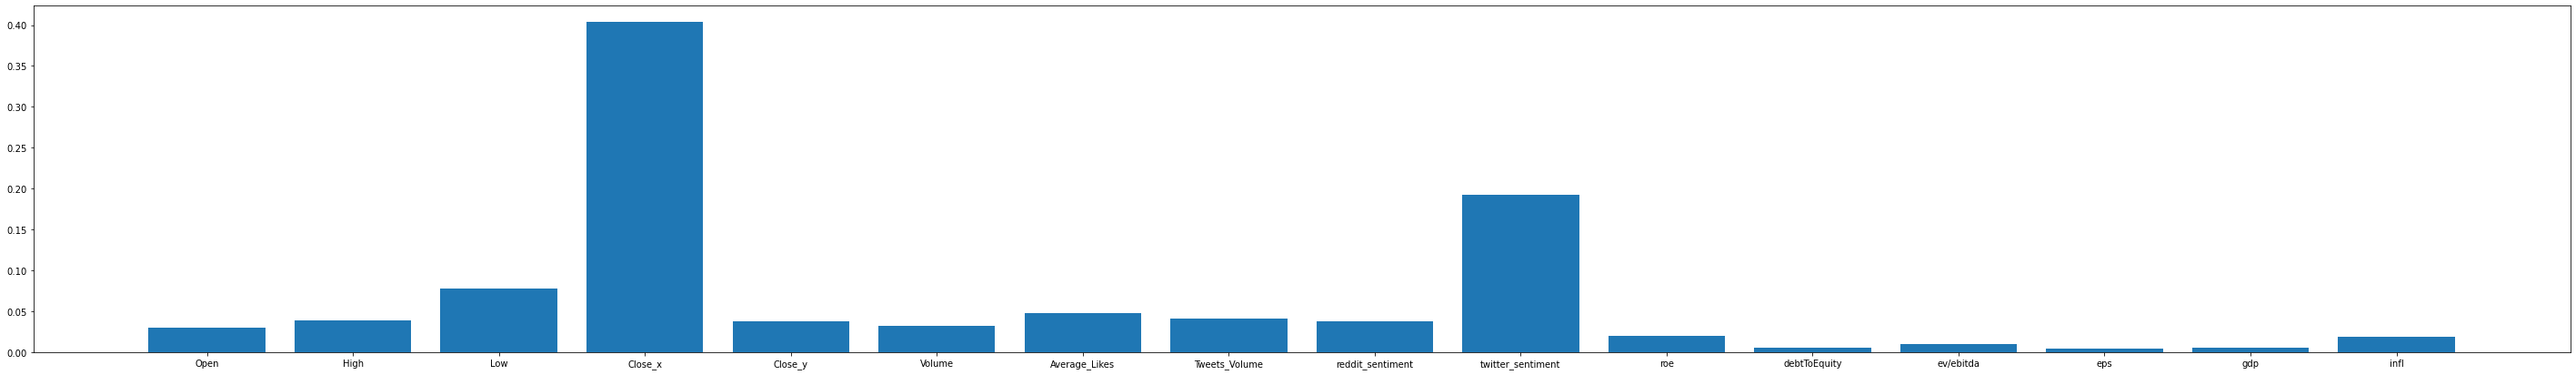

In [52]:
# get importance
importance = best_model.feature_importances_

cols = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'Average_Likes', 'Tweets_Volume','reddit_sentiment', 'twitter_sentiment','roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl']

agg_impt = []
cur = 0
cur_var = 'Open'
at = 0
for i,v in enumerate(importance):
    if (col_order[i].find(cur_var) > -1):
        cur += v
    else: 
        agg_impt.append(cur)
        print(f'Feature: {cols[at]}, Score: {cur:.10f}')
        at += 1
        cur_var = cols[at]
        cur = v
agg_impt.append(cur)
print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([cols[x] for x in range(len(cols))], agg_impt)
plt.show()

### XGBoost Regression Feature Importance

In [53]:
from xgboost import XGBRegressor

best_model = XGBRegressor()
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [54]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past5_XGB', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 8.389800040973112
Mean Squared Error: 110.74423673529868
Root Mean Squared Error: 10.52350876539278
R-squared: 0.29279130504557227


<AxesSubplot:>

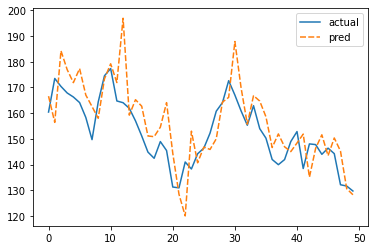

In [55]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-4), Score: 0.0021831396
Feature: Open(t-3), Score: 0.0065798680
Feature: Open(t-2), Score: 0.0043413732
Feature: Open(t-1), Score: 0.0051772958
Feature: Open(t), Score: 0.0000280272
Feature: High(t-4), Score: 0.0147109330
Feature: High(t-3), Score: 0.0176948179
Feature: High(t-2), Score: 0.0209987145
Feature: High(t-1), Score: 0.0017824480
Feature: High(t), Score: 0.0000892238
Feature: Low(t-4), Score: 0.0014762136
Feature: Low(t-3), Score: 0.0233626757
Feature: Low(t-2), Score: 0.0168932267
Feature: Low(t-1), Score: 0.0021812643
Feature: Low(t), Score: 0.0459113903
Feature: Close_x(t-4), Score: 0.0282346122
Feature: Close_x(t-3), Score: 0.0031891142
Feature: Close_x(t-2), Score: 0.0061731176
Feature: Close_x(t-1), Score: 0.0002700559
Feature: Close_x(t), Score: 0.4297297597
Feature: Close_y(t-4), Score: 0.0005440633
Feature: Close_y(t-3), Score: 0.0053861551
Feature: Close_y(t-2), Score: 0.0350519083
Feature: Close_y(t-1), Score: 0.0053521316
Feature: Close_y(t), Score

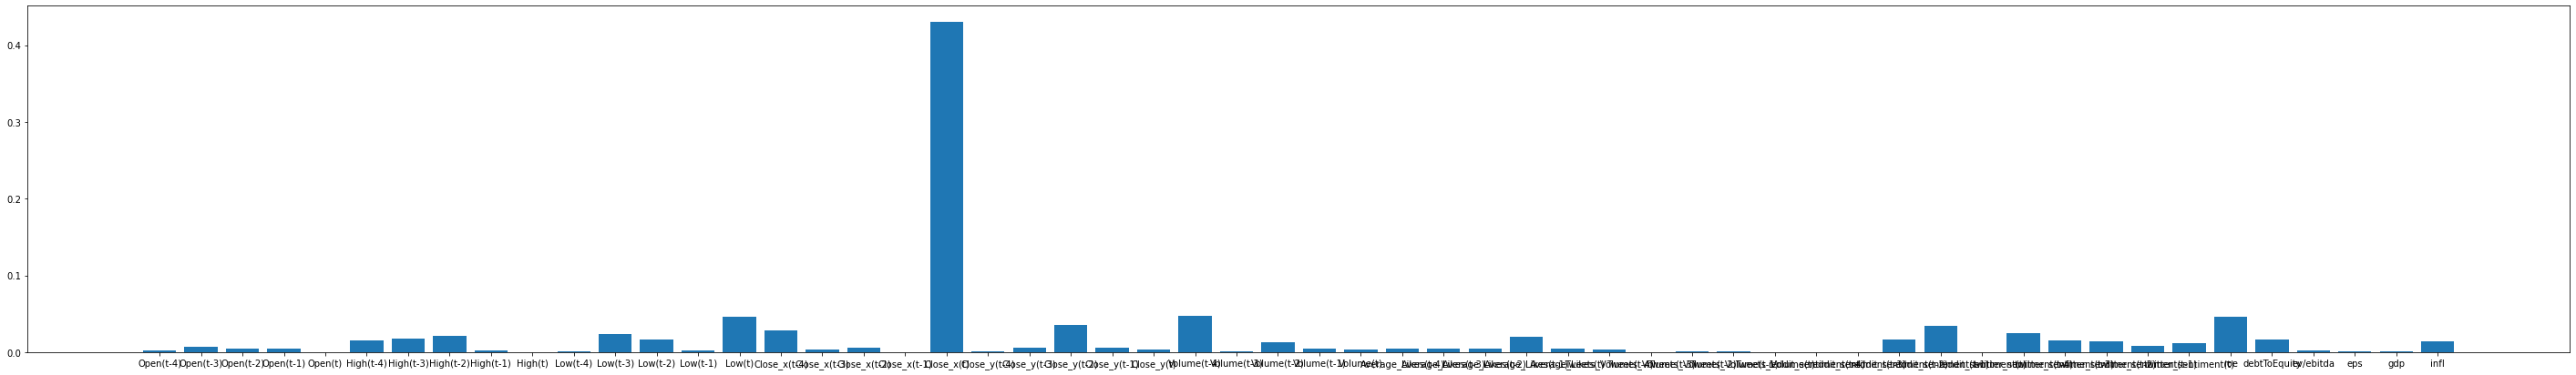

In [56]:
# get importance
importance = best_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

Feature: Open, Score: 0.0183097037
Feature: High, Score: 0.0552761368
Feature: Low, Score: 0.0898247734
Feature: Close_x, Score: 0.4675966501
Feature: Close_y, Score: 0.0496503711
Feature: Volume, Score: 0.0692075565
Feature: Average_Likes, Score: 0.0384093672
Feature: Tweets_Volume, Score: 0.0060538906
Feature: reddit_sentiment, Score: 0.0504154265
Feature: twitter_sentiment, Score: 0.0734977573
Feature: roe, Score: 0.0463177152
Feature: debtToEquity, Score: 0.0159380957
Feature: ev/ebitda, Score: 0.0024244473
Feature: eps, Score: 0.0015258716
Feature: gdp, Score: 0.0010912283
Feature: infl, Score: 0.0144610377


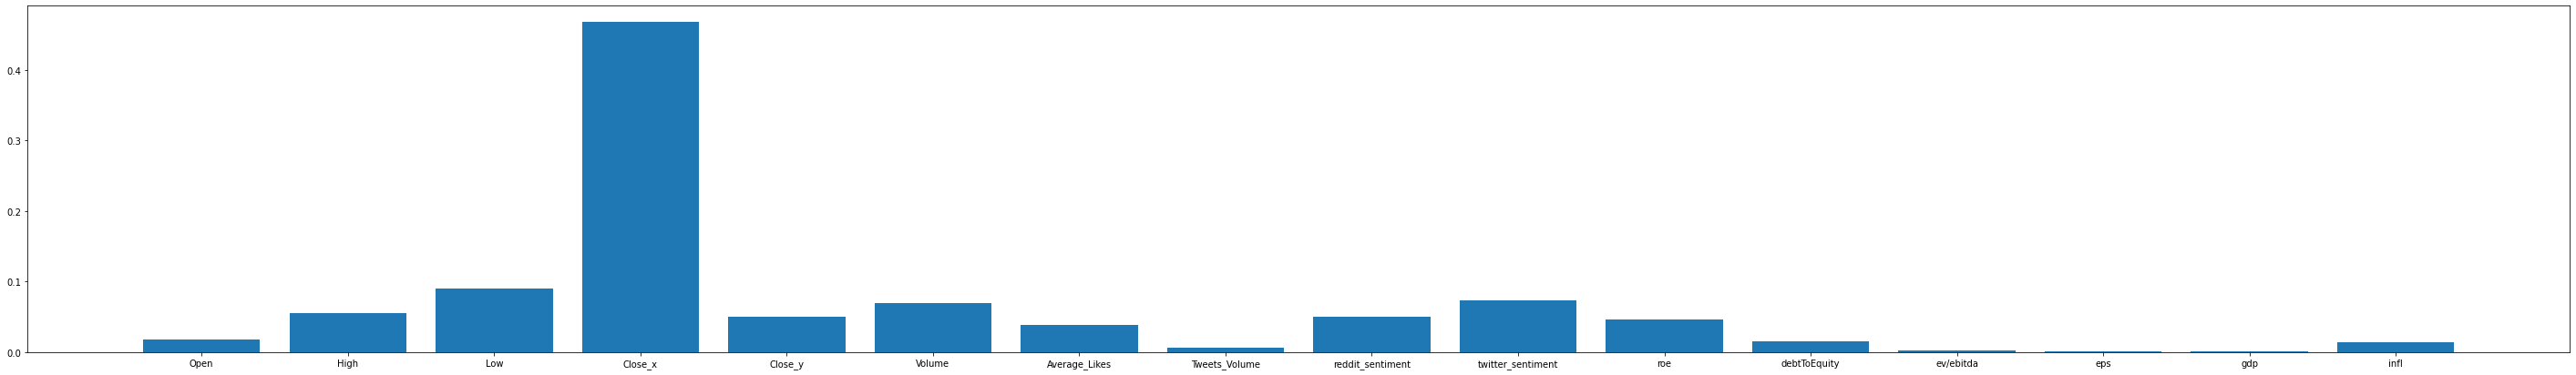

In [57]:
# get importance
importance = best_model.feature_importances_

cols = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume','Average_Likes', 'Tweets_Volume', 'reddit_sentiment', 'twitter_sentiment','roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl']

agg_impt = []
cur = 0
cur_var = 'Open'
at = 0
for i,v in enumerate(importance):
    if (col_order[i].find(cur_var) > -1):
        cur += v
    else: 
        agg_impt.append(cur)
        print(f'Feature: {cols[at]}, Score: {cur:.10f}')
        at += 1
        cur_var = cols[at]
        cur = v
agg_impt.append(cur)
print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([cols[x] for x in range(len(cols))], agg_impt)
plt.show()

### Generate Training Data

In [58]:
train_df.columns

Index(['Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       'High(t-4)', 'High(t-3)', 'High(t-2)', 'High(t-1)', 'High(t)',
       'Low(t-4)', 'Low(t-3)', 'Low(t-2)', 'Low(t-1)', 'Low(t)',
       'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)',
       'Close_x(t)', 'Close_y(t-4)', 'Close_y(t-3)', 'Close_y(t-2)',
       'Close_y(t-1)', 'Close_y(t)', 'Volume(t-4)', 'Volume(t-3)',
       'Volume(t-2)', 'Volume(t-1)', 'Volume(t)', 'Average_Likes(t-4)',
       'Average_Likes(t-3)', 'Average_Likes(t-2)', 'Average_Likes(t-1)',
       'Average_Likes(t)', 'Tweets_Volume(t-4)', 'Tweets_Volume(t-3)',
       'Tweets_Volume(t-2)', 'Tweets_Volume(t-1)', 'Tweets_Volume(t)',
       'reddit_sentiment(t-4)', 'reddit_sentiment(t-3)',
       'reddit_sentiment(t-2)', 'reddit_sentiment(t-1)', 'reddit_sentiment(t)',
       'twitter_sentiment(t-4)', 'twitter_sentiment(t-3)',
       'twitter_sentiment(t-2)', 'twitter_sentiment(t-1)',
       'twitter_sentiment(t)', 'roe', 'debtToE

In [59]:
dropped_cols = ['debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'index']

In [60]:
training_data = train_df.reset_index().drop(columns=dropped_cols, axis=1)

In [61]:
training_data.columns

Index(['Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       'High(t-4)', 'High(t-3)', 'High(t-2)', 'High(t-1)', 'High(t)',
       'Low(t-4)', 'Low(t-3)', 'Low(t-2)', 'Low(t-1)', 'Low(t)',
       'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)',
       'Close_x(t)', 'Close_y(t-4)', 'Close_y(t-3)', 'Close_y(t-2)',
       'Close_y(t-1)', 'Close_y(t)', 'Volume(t-4)', 'Volume(t-3)',
       'Volume(t-2)', 'Volume(t-1)', 'Volume(t)', 'Average_Likes(t-4)',
       'Average_Likes(t-3)', 'Average_Likes(t-2)', 'Average_Likes(t-1)',
       'Average_Likes(t)', 'Tweets_Volume(t-4)', 'Tweets_Volume(t-3)',
       'Tweets_Volume(t-2)', 'Tweets_Volume(t-1)', 'Tweets_Volume(t)',
       'reddit_sentiment(t-4)', 'reddit_sentiment(t-3)',
       'reddit_sentiment(t-2)', 'reddit_sentiment(t-1)', 'reddit_sentiment(t)',
       'twitter_sentiment(t-4)', 'twitter_sentiment(t-3)',
       'twitter_sentiment(t-2)', 'twitter_sentiment(t-1)',
       'twitter_sentiment(t)', 'roe', 'infl', 

In [62]:
training_data

,Open(t-4),Open(t-3),Open(t-2),Open(t-1),Open(t),High(t-4),High(t-3),High(t-2),High(t-1),High(t),...,reddit_sentiment(t-1),reddit_sentiment(t),twitter_sentiment(t-4),twitter_sentiment(t-3),twitter_sentiment(t-2),twitter_sentiment(t-1),twitter_sentiment(t),roe,infl,Close_x1(t+1)
0,37.644696,41.646485,41.157289,41.062932,42.030776,41.357367,42.299396,41.733150,42.553399,43.008290,...,0.000000,0.000000,0.127374,0.256366,0.244529,0.207746,0.318402,0.109210,0.190660,43.286530
1,41.646485,41.157289,41.062932,42.030776,42.570332,42.299396,41.733150,42.553399,43.008290,43.339761,...,0.000000,0.000000,0.256366,0.244529,0.207746,0.318402,0.206934,0.109210,0.237069,45.493195
2,41.157289,41.062932,42.030776,42.570332,43.552680,41.733150,42.553399,43.008290,43.339761,45.582718,...,0.000000,0.000000,0.244529,0.207746,0.318402,0.206934,0.247462,0.109210,0.283478,45.667416
3,41.062932,42.030776,42.570332,43.552680,45.573052,42.553399,43.008290,43.339761,45.582718,47.832951,...,0.000000,0.000000,0.207746,0.318402,0.206934,0.247462,0.230397,0.109210,0.329887,46.272312
4,42.030776,42.570332,43.552680,45.573052,46.373935,43.008290,43.339761,45.582718,47.832951,46.669125,...,0.000000,0.000000,0.318402,0.206934,0.247462,0.230397,0.148224,0.109210,0.376296,48.416073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,149.612990,154.587129,140.195943,151.987936,147.904180,156.999444,154.955949,150.050891,153.355842,151.598536,...,0.000000,0.000000,0.170015,0.066024,0.093421,0.091963,0.043767,0.504836,0.367535,146.406464
196,154.587129,140.195943,151.987936,147.904180,144.070019,154.955949,150.050891,153.355842,151.598536,150.689917,...,0.000000,0.152096,0.066024,0.093421,0.091963,0.043767,0.068209,0.528813,0.304319,144.269730
197,140.195943,151.987936,147.904180,144.070019,146.845798,150.050891,153.355842,151.598536,150.689917,147.075443,...,0.152096,0.158785,0.093421,0.091963,0.043767,0.068209,0.222123,0.528813,0.202989,132.168198
198,151.987936,147.904180,144.070019,146.845798,149.272088,153.355842,151.598536,150.689917,147.075443,149.741373,...,0.158785,0.000000,0.091963,0.043767,0.068209,0.222123,0.105450,0.528813,0.101658,131.658981


In [63]:
training_data.to_csv('training_data.csv', index=False)

### Generate 4 output training_data

In [64]:
final_data = data.copy().drop(columns=['Date', 'dateStr'])
training_data1 = series_to_supervised(final_data, 'Close_x',['roe', 'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl'], 8, 4)

In [65]:
cols_series = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'reddit_sentiment', 'twitter_sentiment']
cols_unival = ['roe', 'infl', 'Close_x1(t+1)', 'Close_x1(t+2)', 'Close_x1(t+3)','Close_x1(t+4)']

In [66]:
col_order = []
cur = pd.Series(training_data1.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered = [x for x in filtered if x.startswith('Close_x1') == False]
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [67]:
training_data1 = training_data1[col_order]

In [68]:
training_data1.columns

Index(['Open(t-7)', 'Open(t-6)', 'Open(t-5)', 'Open(t-4)', 'Open(t-3)',
       'Open(t-2)', 'Open(t-1)', 'Open(t)', 'High(t-7)', 'High(t-6)',
       'High(t-5)', 'High(t-4)', 'High(t-3)', 'High(t-2)', 'High(t-1)',
       'High(t)', 'Low(t-7)', 'Low(t-6)', 'Low(t-5)', 'Low(t-4)', 'Low(t-3)',
       'Low(t-2)', 'Low(t-1)', 'Low(t)', 'Close_x(t-7)', 'Close_x(t-6)',
       'Close_x(t-5)', 'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)',
       'Close_x(t-1)', 'Close_x(t)', 'Close_y(t-7)', 'Close_y(t-6)',
       'Close_y(t-5)', 'Close_y(t-4)', 'Close_y(t-3)', 'Close_y(t-2)',
       'Close_y(t-1)', 'Close_y(t)', 'Volume(t-7)', 'Volume(t-6)',
       'Volume(t-5)', 'Volume(t-4)', 'Volume(t-3)', 'Volume(t-2)',
       'Volume(t-1)', 'Volume(t)', 'reddit_sentiment(t-7)',
       'reddit_sentiment(t-6)', 'reddit_sentiment(t-5)',
       'reddit_sentiment(t-4)', 'reddit_sentiment(t-3)',
       'reddit_sentiment(t-2)', 'reddit_sentiment(t-1)', 'reddit_sentiment(t)',
       'twitter_sentiment(t-7)', 'tw

In [69]:
training_data1.to_csv('training_data1.csv')

## Sentiment Only

In [70]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close_x', 'Volume', 'Close_y', 'roe',
       'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl', 'dateStr',
       'reddit_sentiment', 'twitter_sentiment', 'Tweets_Volume',
       'Average_Likes'],
      dtype='object')

In [71]:
final_data = data.copy()[['Close_x','reddit_sentiment', 'twitter_sentiment']]
train_df = series_to_supervised(final_data, 'Close_x',[], 5, 1)

In [72]:
train_df['change'] = train_df['Close_x1(t+1)'] - train_df['Close_x(t)']

In [73]:
x = train_df.drop(columns=['Close_x1(t+1)', 'change','Close_x(t)', 'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)'], axis=1)
y = train_df['change']

In [74]:
# Take last 50 days as test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [75]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [76]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [77]:
pred = best_model.predict(X_test)
outcome_df = train_df.iloc[153:].copy()
outcome_df['outcome'] = outcome_df['Close_x(t)'] + pred

mae = mean_absolute_error(outcome_df['Close_x1(t+1)'], outcome_df['outcome'])
mse = mean_squared_error(outcome_df['Close_x1(t+1)'],  outcome_df['outcome'])
rmse = mean_squared_error(outcome_df['Close_x1(t+1)'],  outcome_df['outcome'], squared=False)
r2 = r2_score(outcome_df['Close_x1(t+1)'], outcome_df['outcome'])
score_df.loc[len(score_df)] = ['sentiment', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 6.022059485821425
Mean Squared Error: 53.7882848381712
Root Mean Squared Error: 7.334049688826167
R-squared: 0.665165494367068


<AxesSubplot:>

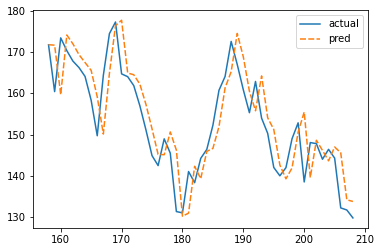

In [78]:
output = pd.DataFrame({'actual': outcome_df['Close_x1(t+1)'], 'pred': outcome_df['outcome']})
sns.lineplot(data=output)

Feature: reddit_sentiment(t-4), Score: -4.581954367714005549316880205879
Feature: twitter_sentiment(t-4), Score: -6.521778211799852620345063769491
Feature: reddit_sentiment(t-3), Score: 1.030378223612021137967076356290
Feature: twitter_sentiment(t-3), Score: -4.630296047547080462436497327872
Feature: reddit_sentiment(t-2), Score: 2.262314149206941404912640791736
Feature: twitter_sentiment(t-2), Score: 3.770977263657734557256162588601
Feature: reddit_sentiment(t-1), Score: 1.629231061300357108478920054040
Feature: twitter_sentiment(t-1), Score: 3.954334971768997508689835740370
Feature: reddit_sentiment(t), Score: 0.420413838573398535025660294195
Feature: twitter_sentiment(t), Score: 4.802771347510843114037015766371


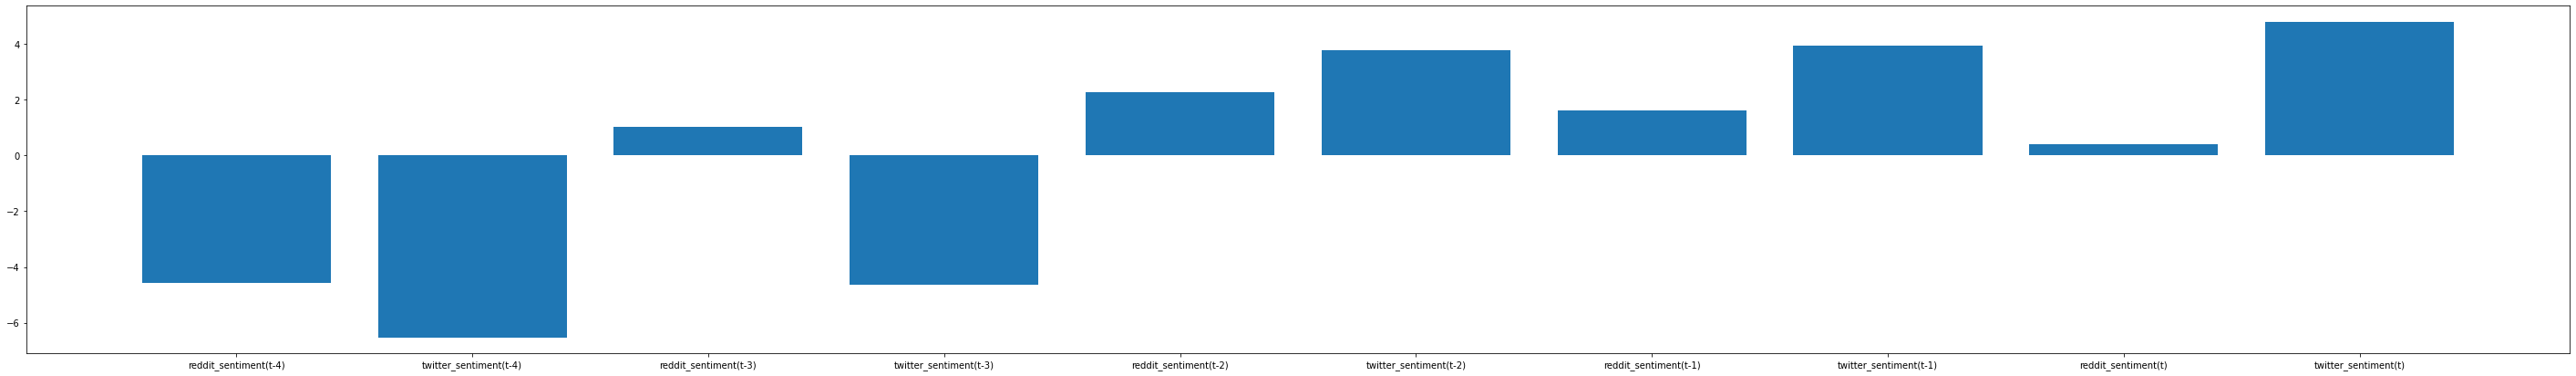

In [79]:
# get importance
importance = best_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {X_train.columns[i]}, Score: {v:.30f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([X_train.columns[y] for y in range(len(importance))], importance)
plt.show()

### Price + Sentiment

In [80]:
final_data = data.copy()[['Close_x', 'Close_y' ,'reddit_sentiment', 'twitter_sentiment']]
train_df = series_to_supervised(final_data, 'Close_x',[], 5, 1)

In [81]:
train_df.columns

Index(['Close_x(t-4)', 'Close_y(t-4)', 'reddit_sentiment(t-4)',
       'twitter_sentiment(t-4)', 'Close_x(t-3)', 'Close_y(t-3)',
       'reddit_sentiment(t-3)', 'twitter_sentiment(t-3)', 'Close_x(t-2)',
       'Close_y(t-2)', 'reddit_sentiment(t-2)', 'twitter_sentiment(t-2)',
       'Close_x(t-1)', 'Close_y(t-1)', 'reddit_sentiment(t-1)',
       'twitter_sentiment(t-1)', 'Close_x(t)', 'Close_y(t)',
       'reddit_sentiment(t)', 'twitter_sentiment(t)', 'Close_x1(t+1)'],
      dtype='object')

In [82]:
cols_series = ['Close_x', 'Close_y', 'reddit_sentiment', 'twitter_sentiment']
cols_unival = ['Close_x1(t+1)']

In [83]:
col_order = []
cur = pd.Series(train_df.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered.remove('Close_x1(t+1)')
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [84]:
train_df = train_df[col_order]

In [85]:
train_scaled = train_df.copy()
train_scaled = train_scaled.reset_index().drop('index', axis=1)

In [86]:
trform_list = {}

In [87]:
def minmaxscalerAdjust(index, row, in_size, num_var, position):
    trform_dict = {}
    trformed_row = []
    value = 0
    for i in range(num_var):
        cur = np.array(row[ i*in_size : (i+1)*in_size ])
        rowmaxmin = cur.max() - cur.min()
        print('rowmaxmin', rowmaxmin)
        rowmin = cur.min()
        print('rowmin', rowmin)
        trform_dict[i] = [rowmaxmin, rowmin]
        trform_list[index] = trform_dict
        cur = [ (x - rowmin) / (rowmaxmin) for x in cur]
        trformed_row.extend(cur)
        if (i == position):
            target = row[-1]
            value = (target - rowmin) / rowmaxmin
    
    rest = np.array(row[ num_var*in_size : -1 ])
    trformed_row.extend(rest)
    trformed_row.append(value)
    return trformed_row

In [88]:
for index, row in train_scaled.iterrows():
    trformed_row = minmaxscalerAdjust(index, row, 5, 2,0)
    train_scaled.loc[index] = trformed_row

rowmaxmin 5.6183929443359375
rowmin 35.640193939208984
rowmaxmin 175.18017578125
rowmin 2549.68994140625
rowmaxmin 5.119674682617195
rowmin 36.13891220092773
rowmaxmin 142.260009765625
rowmin 2582.610107421875
rowmaxmin 3.6018409729003906
rowmin 37.65674591064453
rowmaxmin 131.75
rowmin 2643.85009765625
rowmaxmin 4.499839782714844
rowmin 37.65674591064453
rowmaxmin 152.260009765625
rowmin 2643.85009765625
rowmaxmin 1.7284622192382812
rowmin 40.820106506347656
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 2.4664230346679688
rowmin 40.820106506347656
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 4.258480072021484
rowmin 41.23471450805664
rowmaxmin 57.33984375
rowmin 2775.60009765625
rowmaxmin 3.5108299255371023
rowmin 42.156585693359375
rowmaxmin 49.639892578125
rowmin 2783.300048828125
rowmaxmin 3.723743438720703
rowmin 42.54856872558594
rowmaxmin 83.889892578125
rowmin 2783.300048828125
rowmaxmin 5.129543304443352
rowmin 43.286529541015625
rowmaxmin 112.4699

rowmaxmin 163.8095703125
rowmin 4258.490234375
rowmaxmin 8.937774658203125
rowmin 138.5301971435547
rowmaxmin 163.8095703125
rowmin 4258.490234375
rowmaxmin 6.47320556640625
rowmin 140.99476623535156
rowmaxmin 173.85986328125
rowmin 4258.490234375
rowmaxmin 8.805526733398438
rowmin 140.99476623535156
rowmaxmin 221.2197265625
rowmin 4258.490234375
rowmaxmin 5.766876220703125
rowmin 144.03341674804688
rowmaxmin 92.5498046875
rowmin 4387.16015625
rowmaxmin 7.749420166015625
rowmin 144.03341674804688
rowmaxmin 141.6298828125
rowmin 4387.16015625
rowmaxmin 8.354934692382812
rowmin 144.5976104736328
rowmaxmin 103.080078125
rowmin 4432.35009765625
rowmaxmin 4.7085113525390625
rowmin 148.24403381347656
rowmaxmin 66.7001953125
rowmin 4468.72998046875
rowmaxmin 11.260818481445312
rowmin 141.6917266845703
rowmaxmin 177.7001953125
rowmin 4357.72998046875
rowmaxmin 11.260818481445312
rowmin 141.6917266845703
rowmaxmin 177.7001953125
rowmin 4357.72998046875
rowmaxmin 15.027618408203125
rowmin 137.92

In [89]:
x = train_scaled.drop('Close_x1(t+1)', axis=1)
y = train_scaled['Close_x1(t+1)']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [91]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [92]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [93]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][0][0] + trform_list[x][0][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][0][0] + trform_list[x][0][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['price+sentiment_LR', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 7.370917212238798
Mean Squared Error: 71.99974693992296
Root Mean Squared Error: 8.485266462517425
R-squared: 0.5517983191905587


<AxesSubplot:>

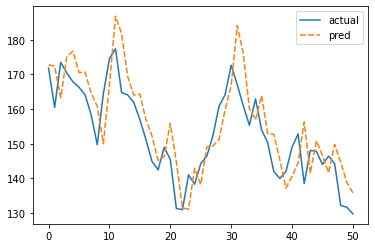

In [94]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

In [95]:
score_df

,vars,mae,mse,rmse
0,past10_LR,12.611811,253.107406,15.909350
1,past5_LR,7.990337,88.882848,9.427770
2,past5_RF,7.146927,72.035743,8.487387
3,past5_XGB,8.389800,110.744237,10.523509
4,sentiment,6.022059,53.788285,7.334050
5,price+sentiment_LR,7.370917,71.999747,8.485266


## Extra EDA

In [96]:
final_data = data.copy()[['Close_x', 'Close_y' ,'reddit_sentiment', 'twitter_sentiment']]
train_eda = series_to_supervised(final_data, 'Close_x',[], 5, 1).reset_index()

In [97]:
from sklearn.preprocessing import MinMaxScaler

scalerPrice = MinMaxScaler()
scalerSentimentT = MinMaxScaler()
scalerSentimentR = MinMaxScaler()
scalerIndexPrice = MinMaxScaler()

In [98]:
train_eda.columns

Index(['index', 'Close_x(t-4)', 'Close_y(t-4)', 'reddit_sentiment(t-4)',
       'twitter_sentiment(t-4)', 'Close_x(t-3)', 'Close_y(t-3)',
       'reddit_sentiment(t-3)', 'twitter_sentiment(t-3)', 'Close_x(t-2)',
       'Close_y(t-2)', 'reddit_sentiment(t-2)', 'twitter_sentiment(t-2)',
       'Close_x(t-1)', 'Close_y(t-1)', 'reddit_sentiment(t-1)',
       'twitter_sentiment(t-1)', 'Close_x(t)', 'Close_y(t)',
       'reddit_sentiment(t)', 'twitter_sentiment(t)', 'Close_x1(t+1)'],
      dtype='object')

In [99]:
train_eda.loc[0, 'price_wo_seasonality' ] = 0
train_eda.loc[0, 'iprice_wo_seasonality'] = 0
for index, row in train_eda.iloc[1:].iterrows():
    train_eda.loc[index,'price_wo_seasonality'] = train_eda.loc[index, 'Close_x(t)'] - train_eda.loc[index-1, 'Close_x(t)']
    train_eda.loc[index,'iprice_wo_seasonality'] = train_eda.loc[index, 'Close_y(t)'] - train_eda.loc[index-1, 'Close_y(t)']

In [100]:
train_eda['price_wo_seasonality'] = [x[0] for x in scalerPrice.fit_transform(np.array(train_eda['price_wo_seasonality']).reshape(-1,1))]

In [101]:
train_eda['iprice_wo_seasonality'] = [x[0] for x in scalerPrice.fit_transform(np.array(train_eda['iprice_wo_seasonality']).reshape(-1,1))]

In [102]:
train_eda['twitter_sentiment(t)'] = [x[0] for x in scalerSentimentT.fit_transform(np.array(train_eda['twitter_sentiment(t)']).reshape(-1,1))]

In [103]:
train_eda['reddit_sentiment(t)'] = [x[0] for x in scalerSentimentR.fit_transform(np.array(train_eda['reddit_sentiment(t)']).reshape(-1,1))]

<AxesSubplot:>

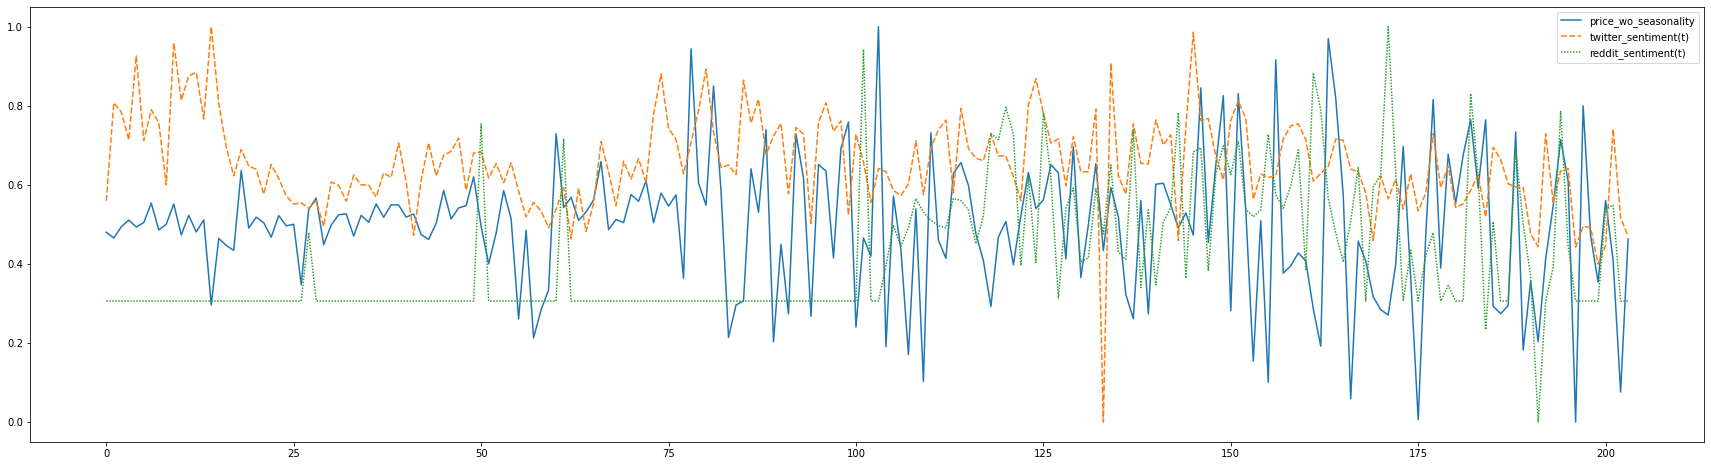

In [104]:
fig = plt.figure(figsize=(30, 8))
sns.lineplot(data=train_eda[['price_wo_seasonality','twitter_sentiment(t)', 'reddit_sentiment(t)']])

<AxesSubplot:>

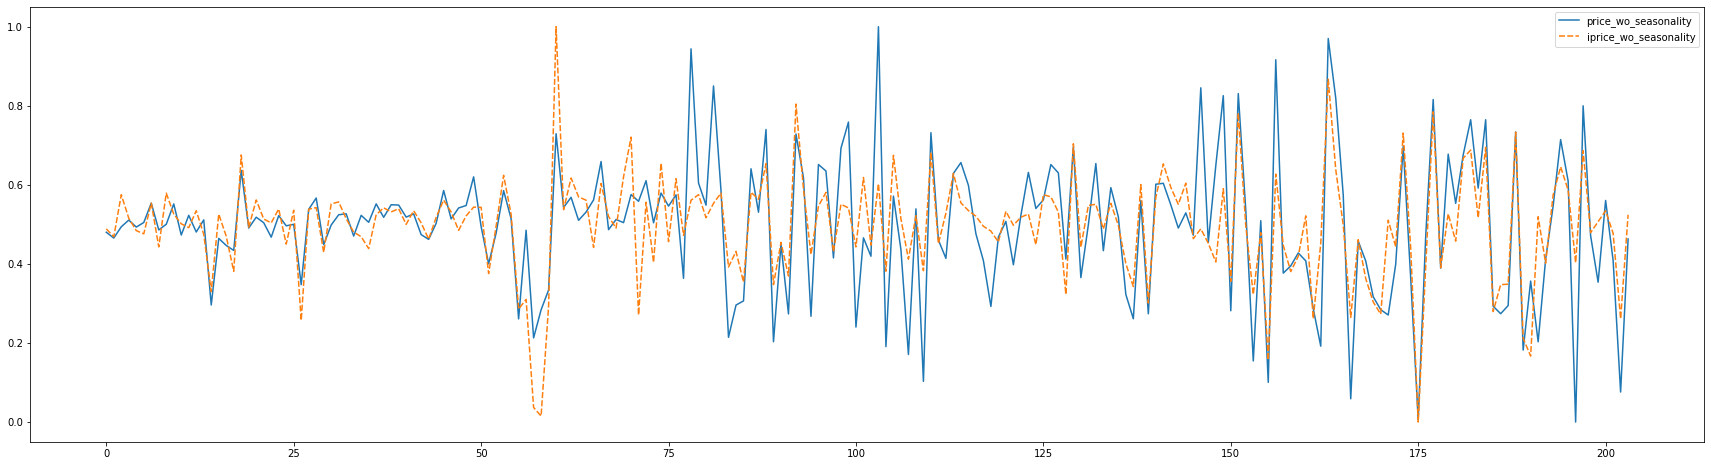

In [105]:
fig = plt.figure(figsize=(30, 8))
sns.lineplot(data=train_eda[['price_wo_seasonality','iprice_wo_seasonality']])